In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/archive (25)/Training'
test_dir = '/content/drive/MyDrive/archive (25)/Testing'

class_labels = sorted(os.listdir(train_dir))  # Globally define this at the top


# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

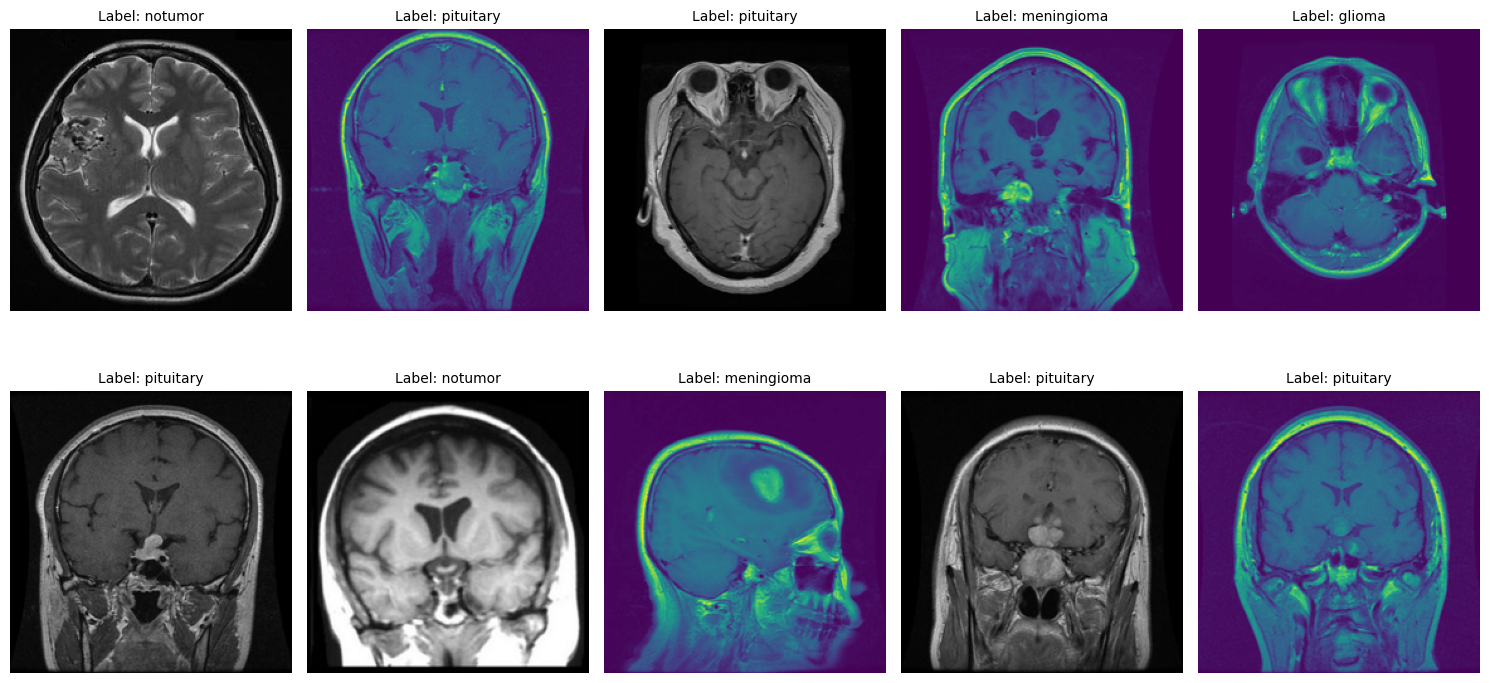

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

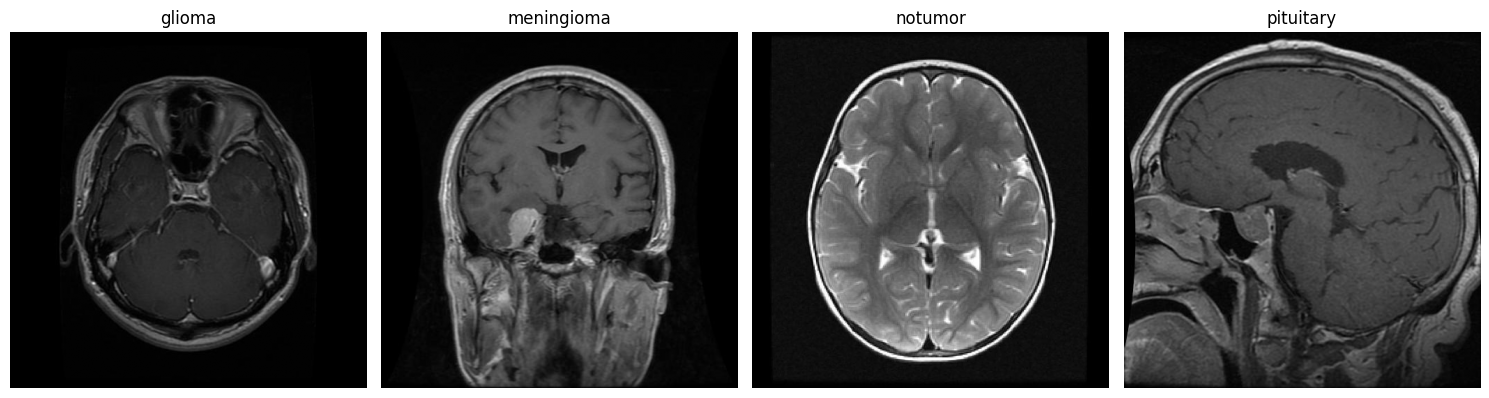

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_first_image_per_class(dataset_path):
    """
    Displays the first image of each class in a dataset in a single line, in grayscale.

    Args:
        dataset_path (str): Path to the dataset directory.
                           It is assumed that the dataset is structured such that
                           each class has its own subdirectory within this path.
    """
    class_names = sorted(os.listdir(dataset_path))
    num_classes = len(class_names)

    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)

        if image_files:
            first_image_path = os.path.join(class_path, image_files[0])
            image = Image.open(first_image_path).convert('L')  # Convert to grayscale
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(class_name)
            axes[i].axis('off')
        else:
             axes[i].text(0.5, 0.5, 'No Image', ha='center', va='center')
             axes[i].set_title(class_name)
             axes[i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Example usage:
    dataset_path = '/content/drive/MyDrive/archive (25)/Training'  # Replace with the actual path to your dataset
    display_first_image_per_class(dataset_path)

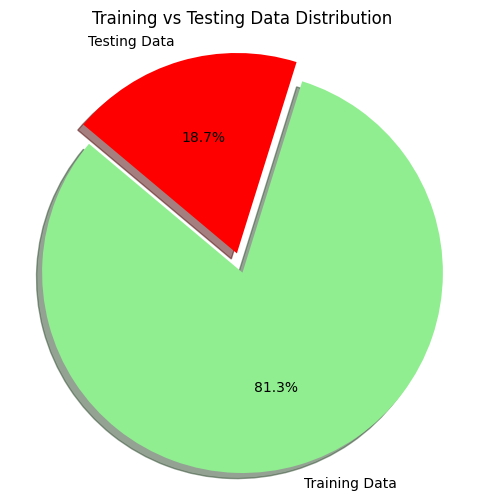

In [6]:
import os
import matplotlib.pyplot as plt

# Define the paths
train_dir = '/content/drive/MyDrive/archive (25)/Training'
test_dir = '/content/drive/MyDrive/archive (25)/Testing'

# Count the number of training images
train_count = sum([len(files) for _, _, files in os.walk(train_dir)])

# Count the number of testing images
test_count = sum([len(files) for _, _, files in os.walk(test_dir)])

# Plot the pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_count, test_count]
colors = ['lightgreen', 'red']
explode = (0.1, 0)  # Slightly offset the training slice

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Training vs Testing Data Distribution')
plt.axis('equal')  # Ensures the pie is a circle
plt.show()

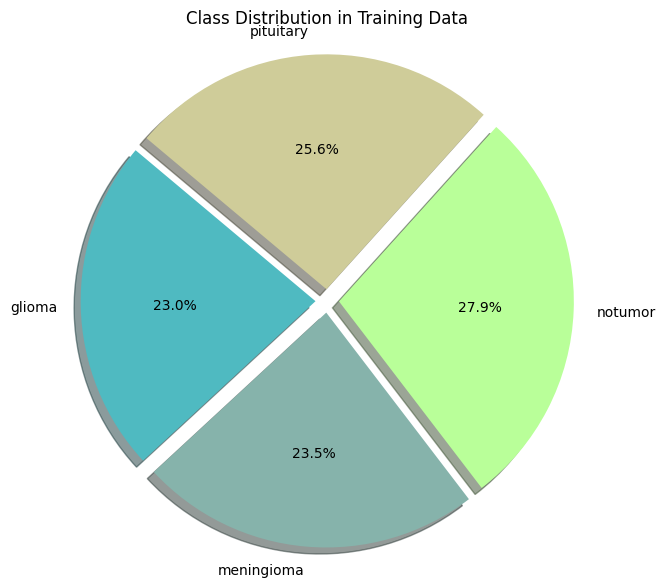

In [7]:
import os
import matplotlib.pyplot as plt

# Path to the training data directory
train_dir = '/content/drive/MyDrive/archive (25)/Training'

# Get the list of class folders
class_labels = sorted(os.listdir(train_dir))

# Count images in each class
class_counts = {}
for label in class_labels:
    class_path = os.path.join(train_dir, label)
    if os.path.isdir(class_path):
        class_counts[label] = len(os.listdir(class_path))

# Custom distinct colors for each class
custom_colors = ['#4FBAC1', '#86B3AB', '#B9FF99', '#CFCC99']  # You can add more colors if needed

# Plot pie chart
labels = list(class_counts.keys())
sizes = list(class_counts.values())
explode = [0.05] * len(labels)  # Slightly "explode" each slice

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        explode=explode, shadow=True, colors=custom_colors)
plt.title('Class Distribution in Training Data')
plt.axis('equal')  # Equal aspect ratio to ensure the pie is circular
plt.show()

In [8]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths, augment=False):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    return np.array([class_labels.index(label) for label in labels])

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1, augment=True):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [9]:
# Model architecture
IMAGE_SIZE = 224 # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

for layer in base_model.layers:
    layer.trainable = False

validation_split=0.1
# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 25

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 1873s 6s/step - loss: 0.5944 - sparse_categorical_accuracy: 0.7626
Epoch 2/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 52s 153ms/step - loss: 0.1937 - sparse_categorical_accuracy: 0.9287
Epoch 3/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9585
Epoch 4/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9708
Epoch 5/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9814
Epoch 6/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9801
Epoch 7/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9855
Epoch 8/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9919
Epoch 9/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - loss: 0.0261 - sparse_categor

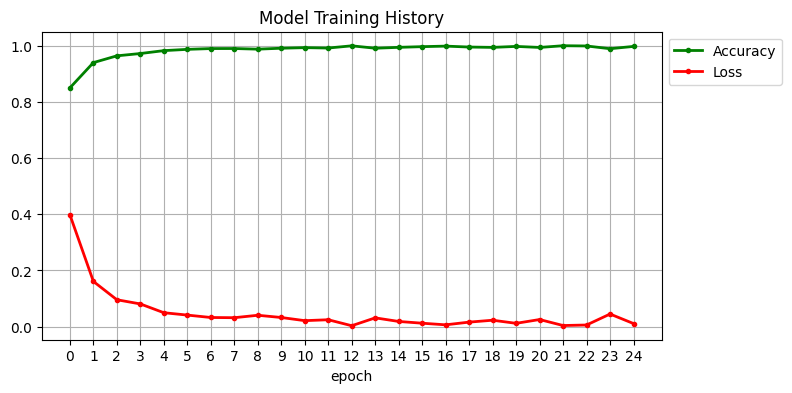

In [10]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths, augment=False)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 278ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       300
           1       0.90      0.99      0.94       310
           2       1.00      1.00      1.00       405
           3       0.97      0.99      0.98       307

    accuracy                           0.97      1322
   macro avg       0.97      0.96      0.96      1322
weighted avg       0.97      0.97      0.97      1322



Confusion Matrix:
[[264  30   0   6]
 [  0 306   1   3]
 [  0   0 405   0]
 [  0   3   0 304]]


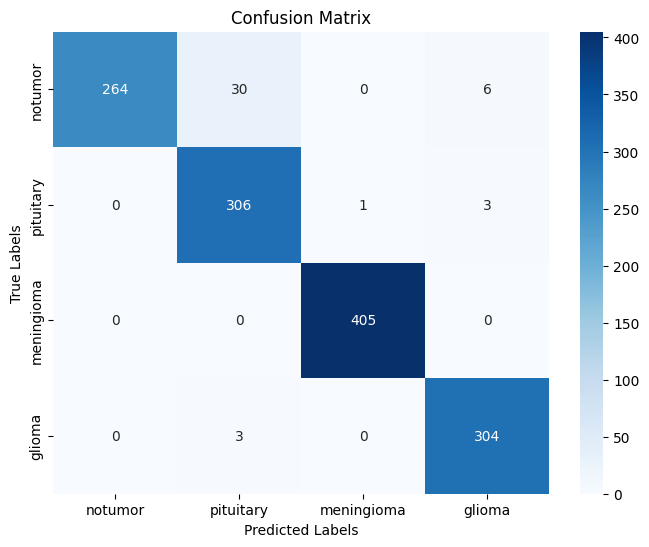

In [12]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

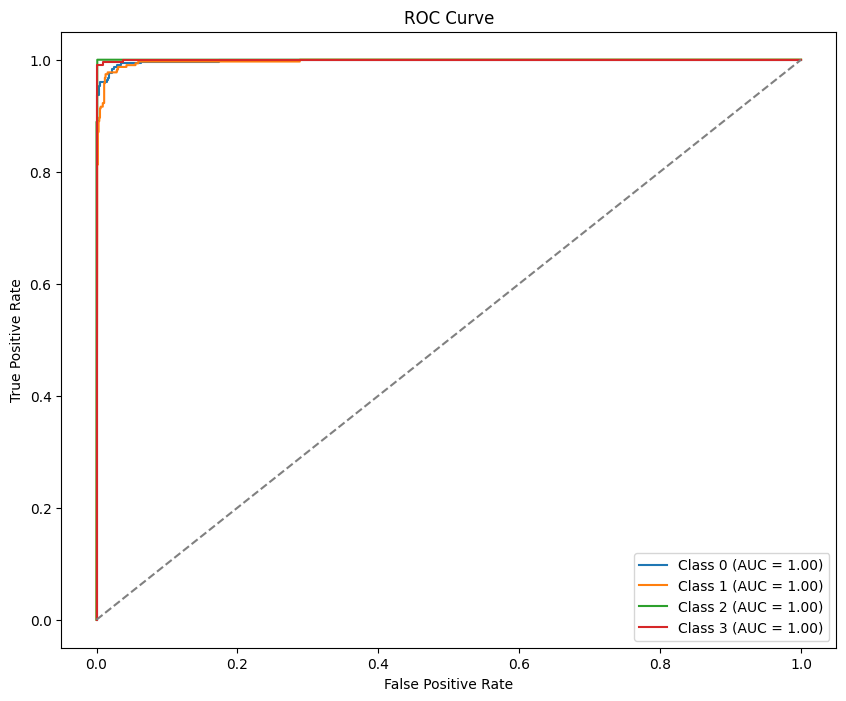

In [13]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [14]:
# Save the entire model
model.save('model.h5')

In [15]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [16]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = sorted(os.listdir(train_dir))

def detect_and_display(img_path, model, image_size=224):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


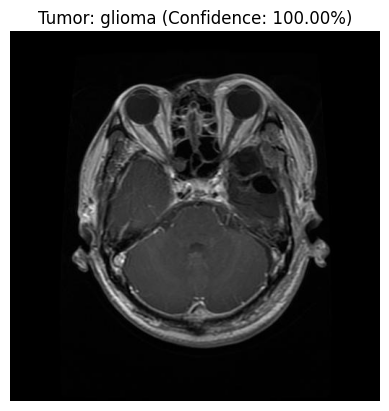

In [17]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/glioma/Te-gl_0011.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


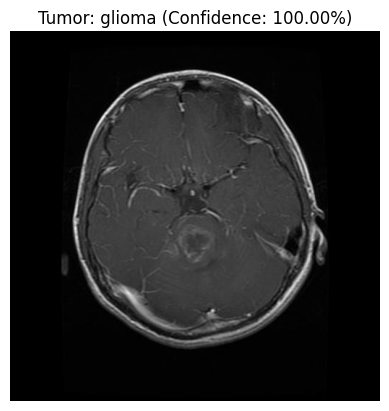

In [18]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/glioma/Te-glTr_0007.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


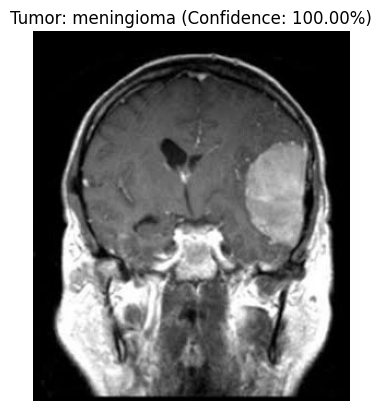

In [19]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/meningioma/Te-me_0016.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


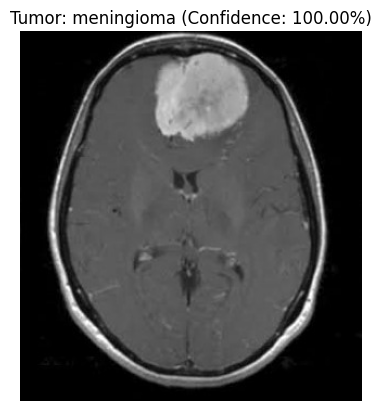

In [20]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/meningioma/Te-me_0027.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


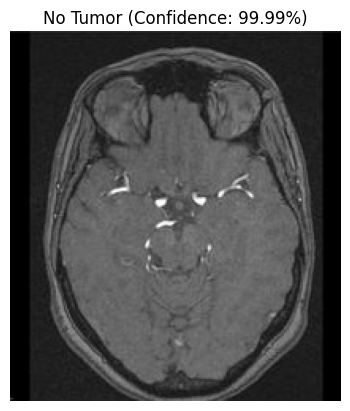

In [21]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/notumor/Te-no_0024.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


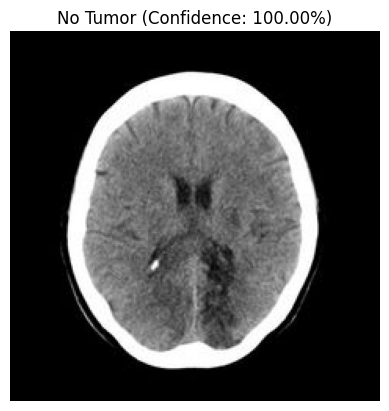

In [22]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/notumor/Te-no_0044.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


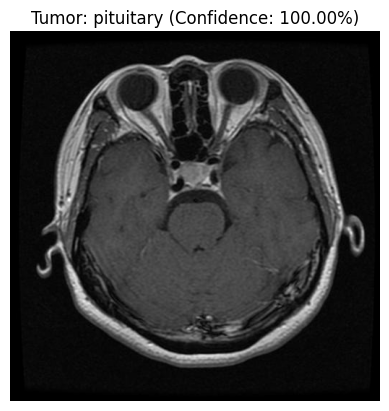

In [23]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/pituitary/Te-pi_0011.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


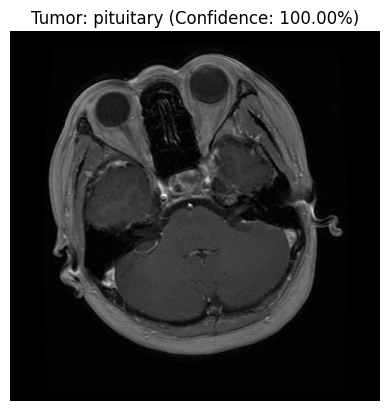

In [24]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/pituitary/Te-pi_0012.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


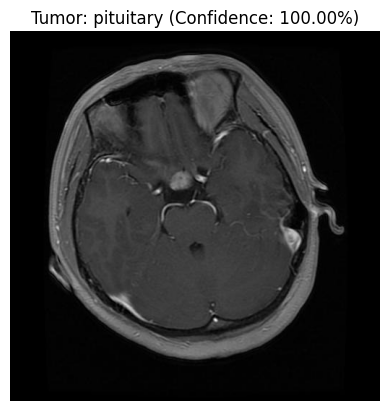

In [25]:
# Example usage
image_path = '/content/drive/MyDrive/archive (25)/Testing/pituitary/Te-pi_0013.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)